In [1]:
import numpy as np
import scipy as sp
from scipy import integrate, interpolate
import scipy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import h5py
import os
import time

In [2]:
# Global Rocket Parameters
xi = 50
Gmu = 1e-12
GammaFrac = 0.1
vf = 0.3
nRockets = 10

# Global Simulation Parameters
tmax = 100
zi = 127
h = 0.7
rhoScale = 4.78e-20 # Mpc / Msun

# Global Physical Parameters
t0 = 4213 / h # Mpc / h
H0 = 0.0003333

Lbox = 100
LLowRes, LHighRes = [100, 1]
binsLowRes, binsHighRes = [100, 100]
dxHighRes, dxLowRes = [LLowRes / binsLowRes, LHighRes / binsHighRes]
boxC = np.asarray([LLowRes / 2 for i in range(3)])

In [8]:
# Set the Environment
envi = 1
envs = ["Cluster", "Local"]
env = envs[envi]

if env == "Cluster":
    # Cluster dirs
    neilDir = "/cluster/tufts/hertzberglab/nshah14/"
    homeDir = "/cluster/tufts/hertzberglab/shared/Rockets/"
    simName = "Sim_100v"
    simDir = homeDir + simName + "/"
    Div = "/"
elif env == "Local":
    # Cluster dirs
    homeDir = "C:\\Users\\NeilShah\\Documents\\PhD\\Rocket Capture\\"
    simName = "Sim_100v"
    simDir = homeDir + simName + "\\"
    Div = "\\"

print("Working in the {} environment".format(env))

Working in the Local environment


In [4]:
def getHubbleEvol():
    OMatter = 0.25
    OLambda = 0.75

    da_dt = lambda a, t: a * H0 * np.sqrt(OMatter / a**3 + OLambda)

    a0 = 1 / (1 + zi)
    tInt = np.linspace(0, 1.1 / H0, 1000)
    af = interpolate.InterpolatedUnivariateSpline(tInt, integrate.odeint(da_dt, y0=a0, t=tInt)[:, 0])
    aDotf = af.derivative(n=1)
    tEnd = sp.optimize.fsolve(lambda t: af(t) - 1.0, x0=(1.0 / H0))[0]

    tArr = np.asarray([(tEnd + t)**(t / tmax) - 1 for t in range(tmax)])
    aArr = np.asarray([af(t) for t in tArr])
    HArr = np.asarray([aDotf(t) / af(t) for t in tArr])

    return tArr, aArr, HArr

In [5]:
def getMass(t):
    snapDir = simDir + "snapdir_{:03d}{}".format(t, Div)
    snapPaths = np.asarray(os.listdir(snapDir))

    ptypeN = 3
    massArr = [np.empty(0, dtype=float) for i in range(ptypeN)]
    for pi in range(ptypeN):
        ptype = pi + 1
        for pathi, path in enumerate(snapPaths):
            datGet = "/PartType{:d}/Masses".format(ptype)
            try:
                masses = np.asarray(h5py.File(snapDir + path, 'r')[datGet])
                massArr[pi] = np.concatenate([massArr[pi], masses], axis=0)
            except KeyError:
                # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
                pass
    
    return(massArr)

In [6]:
def toMS(t):
    s = np.floor(np.mod(t, 60))
    m = np.floor(np.mod(t, 3600) / 60)
    h = np.floor(t / 3600)

    if t < 1:
        tstr = "{:f} s".format(t)
    elif t < 3600:
        tstr = "{:02d}m {:02d}s".format(int(m), int(s))
    else:
        tstr = "{}h {:02d}m {:02d}s".format(int(h), int(m), int(s))
    return tstr

In [7]:
def getCoords(t):
    snapDir = simDir + "snapdir_{:03d}{}".format(t, Div)
    pathArr = np.asarray(os.listdir(snapDir))
    
    ptypeN = 3
    coordsArr = [np.empty((0, 3), dtype=float) for i in range(ptypeN)]

    for pi in range(ptypeN):
        ptype = pi + 1
        for pathi in np.arange(0, pathArr.size):
            datGet = "/PartType{:d}/Coordinates".format(ptype)
            try:
                coords = np.asarray(h5py.File(snapDir + pathArr[pathi], 'r')[datGet])
                coordsArr[pi] = np.concatenate([coordsArr[pi], coords], axis=0)
            except KeyError:
                # print("   (Warning! Could not find ptype {:d} for snapshot t = {:d})".format(ptype, t))
                pass
    
    return(coordsArr)

def getHaloCoords(t):
    haloPtype = 1

    groupDir = simDir + "groups_{:03d}{}".format(t, Div)
    snapDir = simDir + "snapdir_{:03d}{}".format(t, Div)
    groupPaths = np.asarray(os.listdir(groupDir))
    snapPaths = np.asarray(os.listdir(snapDir))

    coordsArr = getCoords(t)[haloPtype - 1]
    
    haloCoords = np.empty((0, 0))
    for i, pathi in enumerate(groupPaths):
        gfile = h5py.File(groupDir + pathi, 'r')
        try:
            haloInit = int(np.asarray(gfile["/Group/GroupOffsetType/"])[0, haloPtype - 1])
            haloN = int(np.asarray(gfile["/Group/GroupLen/"])[haloPtype - 1])
            haloCoords = coordsArr[haloInit:(haloInit + haloN + 1), :]
            break
        except KeyError:
            pass
    
    return(haloCoords)

def getHaloC(t):
    haloCoords = getHaloCoords(t)
    if haloCoords.shape[0] == 0:
        print("Warning! Invalid Time, No File Found")
        return -1 + np.zeros(3)
    else:
        xc = np.asarray([np.mean(haloCoords[:, i]) for i in range(3)])
    return(xc)

def getRVir(t):
    groupDir = simDir + "groups_{:03d}{}".format(t, Div)
    groupPaths = np.asarray(os.listdir(groupDir))
    
    RVir200, RVir500 = [0, 0]
    for i, pathi in enumerate(groupPaths):
        file = h5py.File(groupDir + pathi, 'r')
        try:
            RVir200 = np.asarray(file["/Group/Group_R_Crit200"])[0]
            RVir500 = np.asarray(file["/Group/Group_R_Crit500"])[0]
            break
        except KeyError:
            pass
    return RVir200, RVir500

def getHaloMass(t):
    haloCoords = getHaloCoords(t)
    haloC = getHaloC(t)
    RVir200, RVir500 = getRVir(t)
    massArr = getMass(t)
    haloPType = 1

    totMass = 0
    for i, coord in enumerate(haloCoords):
        if np.linalg.norm(coord - haloC) < RVir200:
            totMass += massArr[haloPType - 1][i]
    return(1e10 * totMass)

The initial center of the halo is at: (43.462195 41.761871 43.680216)


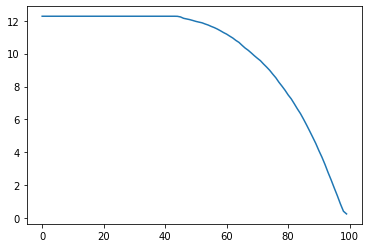

In [8]:
haloCArr = np.load(homeDir + "haloCArr.npy")
print("The initial center of the halo is at: ({:f} {:f} {:f})".format(*haloCArr[0, :]))
catch = plt.plot(range(haloCArr.shape[0]), np.asarray([np.linalg.norm(haloCArr[i, :] - boxC) for i in range(haloCArr.shape[0])]))

In [31]:
FgArr = np.load(homeDir + "FgArr.npy")
FgMagArr = np.asarray([[np.linalg.norm(FgArr[i, :, t]) for t in range(tmax)] for i in range(FgArr.shape[0])])

In [82]:
FgMagArr[:, 2]

array([6.10141089e-06, 6.10137435e-06, 4.78638024e-06, ...,
       6.04170060e-06, 6.04153295e-06, 4.78654488e-06])

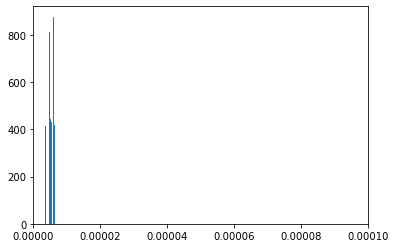

In [80]:
plt.hist(FgMagArr[:, 5], bins=10)
plt.xlim([0, 1e-4])
# plt.ylim([0, 2000])
plt.show()

In [37]:
H0 * GammaFrac / xi

6.666e-07

In [16]:
rocketDir = homeDir + "RocketTrajs_HC{}".format(Div)
rocketPath = rocketDir + "RT_HC__LRTesting__NoFRocket.npy"

xArr, vArr = np.load(rocketPath)
xArr[0, :, 0]

array([43.54670988, 41.70451369, 43.67028502])

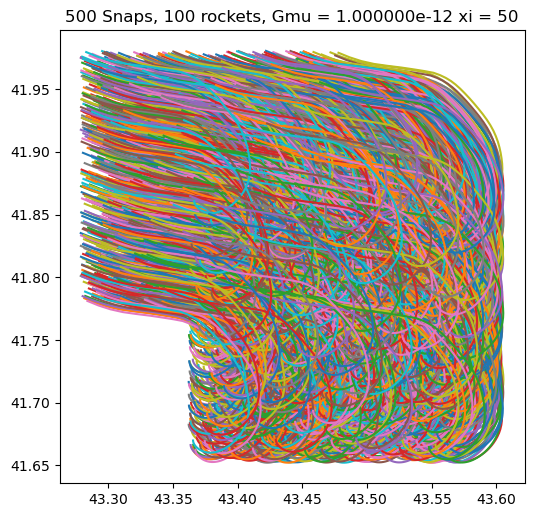

In [11]:
rocketDir = homeDir + "RocketTrajs_HC{}".format(Div)
rocketPath = rocketDir + "RT_HC__LRTesting__NoFRocket.npy"

xArr, vArr = np.load(rocketPath)
RVir200, RVir500 = getRVir(tmax)
haloC = boxC

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
axs = [ax]

pltN = xArr.shape[0]
t1, t2 = [0, 100]
haloCs = np.load(homeDir + "haloCArr.npy")
[axs[0].plot(xArr[i, 0, t1:t2], xArr[i, 1, t1:t2]) for i in range(xArr.shape[0])]
# axs[0].plot(haloCs[:100, 0], haloCs[:100, 1], '--ok', zorder=9)
# [axs[1].plot(xArr[i, 0, -1], xArr[i, 1, -1], 'ok') for i in range(xArr.shape[0])]
for i, ax in enumerate(axs):
    # ax.set_xlim([haloC[0] - LHighRes, haloC[0] + LHighRes])
    # ax.set_ylim([haloC[1] - LHighRes, haloC[1] + LHighRes]) 
    ax.title.set_text("500 Snaps, {} rockets, Gmu = {:e} xi = {}".format(xArr.shape[2], Gmu, xi))
    # ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, linewidth=4, zorder=10))

plt.show()

[(3400, 3, 100), (3400, 3, 498)]


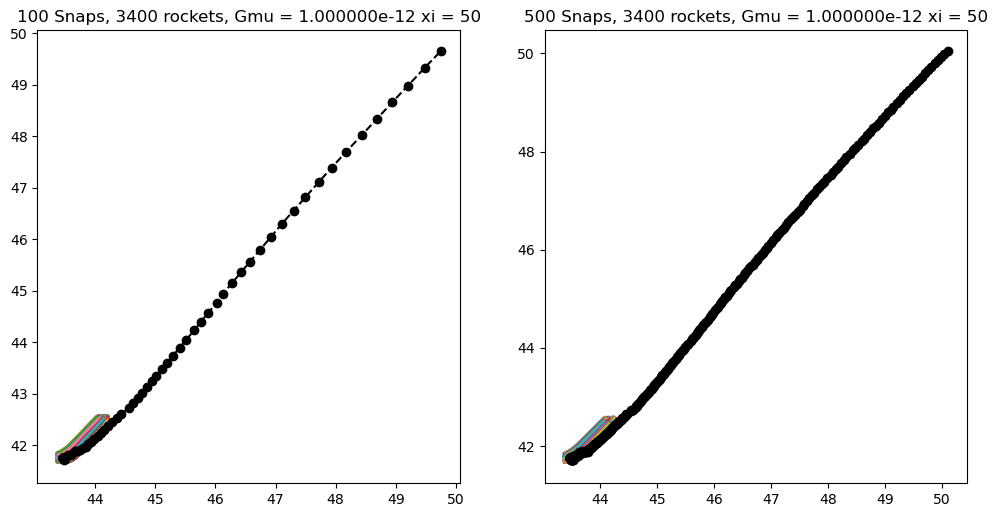

In [56]:
rocketDir = homeDir + "RocketTrajs_HC{}".format(Div)
rocketPath1 = rocketDir + "RT_HC__N_003400__Gmu_1e-14__xi_050_NoFRocket.npy"
rocketPath2 = rocketDir + "RT_HC__Sim_500v__N_003400__Gmu_1e-14__xi_050__NoFRocket.npy"

xArr1, vArr1 = np.load(rocketPath1)
xArr2, vArr2 = np.load(rocketPath2)
print([xArr1.shape, xArr2.shape])
RVir200, RVir500 = getRVir(tmax)
haloC = boxC

fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

t1, t2 = [0, xArr.shape[0]]
haloCs1 = np.load(homeDir + "haloCArr.npy")
haloCs2 = np.load(homeDir + "haloCArr_Sim_500v.npy")
[axs[0].plot(xArr1[i, 0, :], xArr1[i, 1, :]) for i in range(xArr1.shape[0])]
[axs[1].plot(xArr2[i, 0, :], xArr2[i, 1, :]) for i in range(xArr2.shape[0])]

haloT = 99
axs[0].plot(haloCs1[0:haloT, 0], haloCs1[0:haloT, 1], '--ok', zorder=9)
axs[1].plot(haloCs2[0:(5*haloT), 0], haloCs2[0:(5*haloT), 1], '--ok', zorder=9)

snaps = [100, 500]
for i, ax in enumerate(axs):
    ax.title.set_text("{} Snaps, {} rockets, Gmu = {:e} xi = {}".format(snaps[i], xArr.shape[0], Gmu, xi))

plt.show()

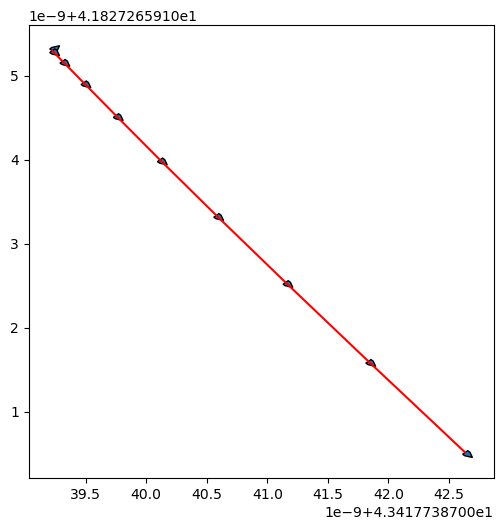

In [55]:
rocketDir = homeDir + "RocketTrajs_HC{}".format(Div)
rocketPath = rocketDir + "RT_HC__Sim_500v__N_003400__Gmu_1e-14__xi_050__NoFRocket.npy"
xArr, vArr = np.load(rocketPath)
FgArr = np.load(homeDir + "FgArr__Sim_500v.npy")

id = 0

t1, t2 = [0, 10]
FgScale = 0.01 * np.max(np.asarray([np.linalg.norm(xArr[id, i, t2] - xArr[id, i, t1]) for i in range(3)]))
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=100)
ax.plot(xArr[id, 0, t1:t2], xArr[id, 1, t1:t2], color='r')
for t in range(t1, t2):
    FgX, FgY = [FgScale * FgArr[id, 0, t] / np.linalg.norm(FgArr[id, 0, t]), FgScale * FgArr[id, 1, t] / np.linalg.norm(FgArr[id, 1, t])]
    ax.arrow(xArr[id, 0, t], xArr[id, 1, t], FgX, FgY, length_includes_head=True, width=FgScale, head_width=FgScale, head_length=FgScale)

plt.show()

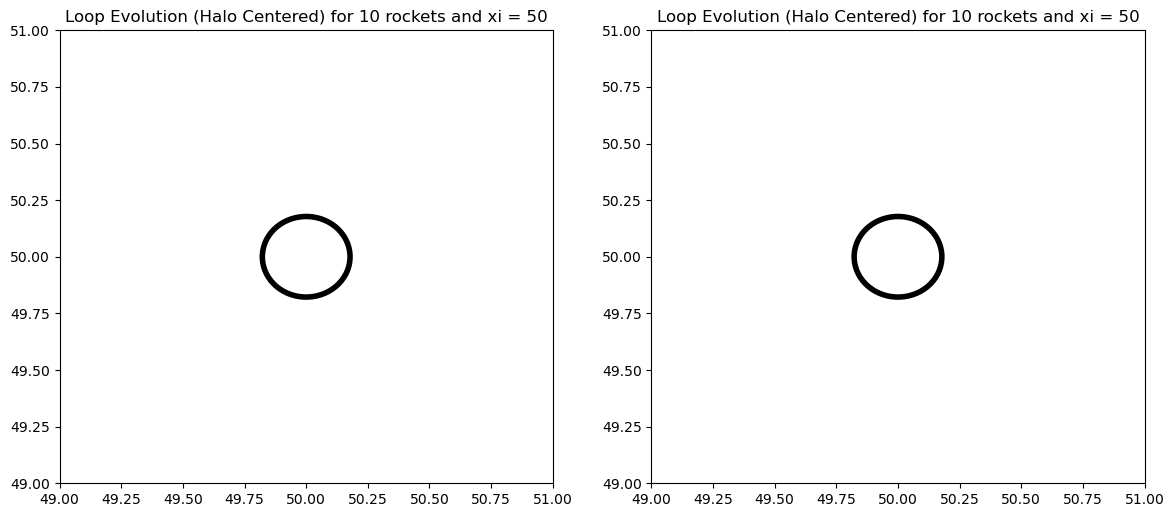

In [23]:
rocketDir = homeDir + "RocketTrajs_HC{}".format(Div)
rocketPath = rocketDir + "RT_HC__N_003400__Gmu_1e-14__xi_050__NoFRocket.npy"

xArr, vArr = np.load(rocketPath)
RVir200, RVir500 = getRVir(tmax)
haloC = boxC

fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

pltN = xArr.shape[0]
tlim = tmax
[axs[0].plot(xArr[i, 0, 0:tlim], xArr[i, 1, 0:tlim]) for i in range(xArr.shape[0])]
[axs[1].plot(xArr[i, 0, -1], xArr[i, 1, -1], 'ok') for i in range(xArr.shape[0])]
for i, ax in enumerate(axs):
    ax.set_xlim([haloC[0] - LHighRes, haloC[0] + LHighRes])
    ax.set_ylim([haloC[1] - LHighRes, haloC[1] + LHighRes]) 
    ax.title.set_text("Loop Evolution (Halo Centered) for {} rockets and xi = {}".format(nRockets, xi))
    ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, linewidth=4, zorder=10))

plt.show()

In [ ]:
rocketDir = homeDir + "RocketTrajs_HC{}".format(Div)
rocketPath = rocketDir + "RT_HC__Run4__N_003400__xi_050.npy"
rocketSave = homeDir + "RocketTrajPlts{}".format(Div)
if not os.path.exists(rocketSave):
    os.makedirs(rocketSave)
xArr, vArr = np.load(rocketPath)
RVir200, RVir500 = getRVir(tmax)
haloC = boxC

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
fig.patch.set_facecolor("white")
axs = [ax]

t0 = time.time()
for t in range(1, tmax):
    print("Processing t = {}/{} (Time Elapsed: {}, Estimated Time Remaining: {})".format(t, tmax, toMS(time.time() - t0), toMS((tmax / t - 1) * (time.time() - t0))), end="\r")

    pltN = xArr.shape[0]
    [axs[0].plot(xArr[i, 0, 0:t], xArr[i, 1, 0:t]) for i in range(pltN)]
    # [axs[1].plot(xArr[i, 0, -1], xArr[i, 1, -1], 'ok') for i in range(pltN)]
    for i, ax in enumerate(axs):
        ax.set_xlim([haloC[0] - LHighRes, haloC[0] + LHighRes])
        ax.set_ylim([haloC[1] - LHighRes, haloC[1] + LHighRes])
        ax.title.set_text("Loop Evolution (Halo Centered) for {} rockets and xi = {} (t = {:03d}/{:03d})".format(nRockets, xi, t, tmax))
        ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, linewidth=4, zorder=10))

    plt.savefig(rocketSave + "rocketTrajs__t_{:03d}.png".format(t))
    plt.cla()
    print(" "*100, end="\r")

In [10]:
haloMass = getHaloMass(tmax)

0.0008352748188263932


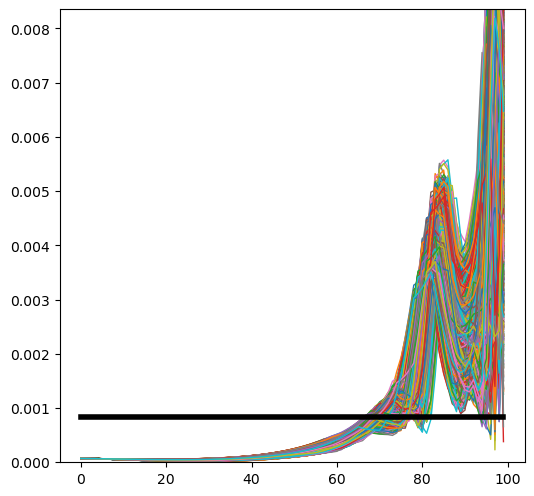

In [11]:
tArr, aArr, HArr = getHubbleEvol()

vEsc = np.sqrt(2 * haloMass * rhoScale / RVir200)
print(vEsc)
vMags = np.asarray([[np.linalg.norm(vArr[i, :, j]) for j in range(vArr.shape[2])] for i in range(vArr.shape[0])])

fig = plt.subplots(figsize=(6, 6), dpi=100)
[plt.plot(np.arange(tmax), aArr * vMags[i, :], linewidth=1) for i in range(vMags.shape[0])]
plt.plot(np.arange(tmax), np.zeros(tmax) + vEsc, '-k', linewidth=4)
plt.ylim([0, 10 * vEsc])
plt.show()

In [36]:
haloCoords = getCoords(tmax)
haloMasses = getMass(tmax)

In [39]:
print(haloCoords[0].shape)
print(haloMasses[0].shape)

(3055679, 3)
(3055679,)


In [60]:
distArr = np.asarray([np.linalg.norm(xArr[i, :, -1] - boxC) for i in range(xArr.shape[0])])
ii = np.where(distArr == np.min(distArr))[0][0]
print(ii)

838


In [55]:
distArr = np.asarray([np.linalg.norm(xArr[i, :, -1] - boxC) for i in range(xArr.shape[0])])
ii = np.where(distArr == np.min(distArr))[0][0]

def getPE(pos):
    PEi = 0
    for ptype in range(3):
        for i in range(haloCoords[ptype].shape[0]):
            PEi += haloMasses[ptype][i] * rhoScale / np.linalg.norm(pos - haloCoords[ptype][i])
    
    return -PEi

# KETab = np.asarray([0.5 * np.linalg.norm(vArr[i, :, -1])**2 for i in range(1)])
# PETab = np.asarray([getPE(xArr[i, :, -1]) for i in range(1)])
KETab = np.asarray([0.5 * np.linalg.norm(vArr[ii, :, -1])**2])
PETab = np.asarray([getPE(xArr[ii, :, -1])])

In [56]:
print(KETab)
print(PETab)

[6.23750147e-07]
[-8.04014583e-15]


In [22]:
vEsc

0.0008352748188263932

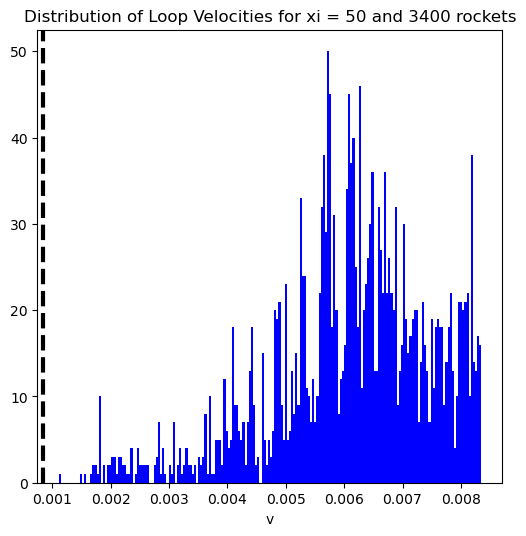

In [21]:
vEsc = np.sqrt(2 * haloMass * rhoScale / RVir200)
vMags = np.asarray([[np.linalg.norm(vArr[i, :, j]) for j in range(vArr.shape[2])] for i in range(vArr.shape[0])])
fig = plt.subplots(figsize=(6, 6), dpi=100)
vMagsSelect = vMags[vMags[:, -1] < 10*vEsc, -1]
plt.hist(vMagsSelect, bins=200, color='b') 
# plt.xlim([0, 2 * vEsc])
# plt.ylim([0, 10])
plt.xlabel("v")
plt.title("Distribution of Loop Velocities for xi = {} and {} rockets".format(xi, vArr.shape[0]))
plt.axvline(vEsc, color='k', linestyle='dashed', linewidth=3)
plt.show()

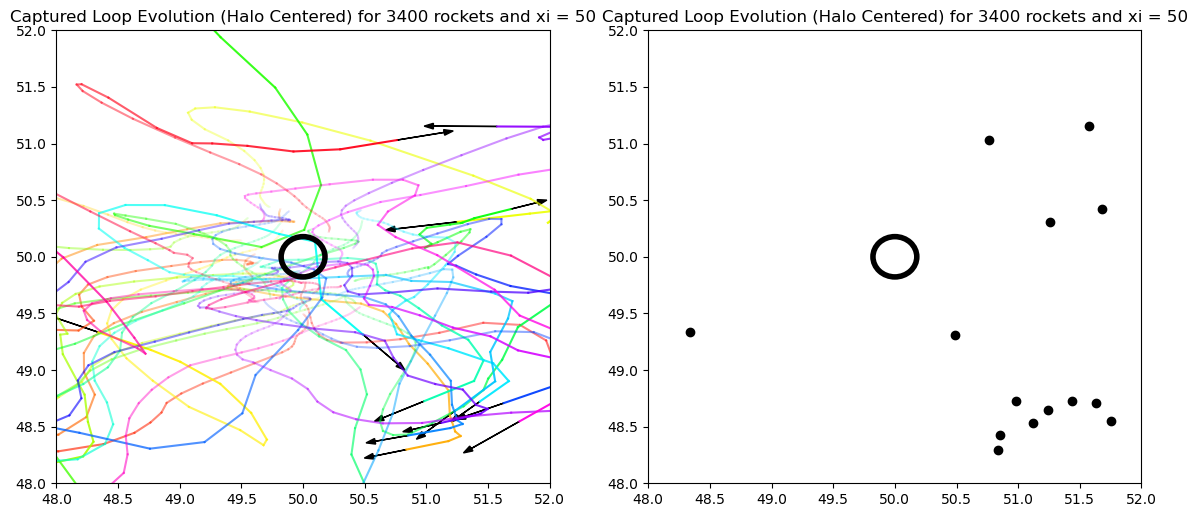

In [14]:
haloC = np.asarray([Lbox / 2 for i in range(3)])
capturedIds = np.asarray([i if vMags[i, -1] < vEsc else 0 for i in range(vMags.shape[0])]).nonzero()[0]
fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

colorArr = plt.cm.get_cmap('hsv', capturedIds.size)
# [[axs[0].plot(xArr[i, 0, j:j+2], xArr[i, 1, j:j+2], '-', color=colorArr(i), alpha=(j / (tmax - 1))) for j in range(tmax - 1)] for i in capturedIds]
[axs[1].plot(xArr[i, 0, -1], xArr[i, 1, -1], 'ok') for i in capturedIds]

for i, cI in enumerate(capturedIds):
    xc = xArr[cI, 0, -1]
    yc = xArr[cI, 1, -1]
    dxA = xArr[cI, 0, -1]-xArr[cI, 0, -2]
    dyA = xArr[cI, 1, -1]-xArr[cI, 1, -2]
    # dxA = vArr[cI, 0, -1]
    # dyA = vArr[cI, 1, -1]
    axs[0].arrow(xc, yc, dxA, dyA, shape="full", length_includes_head=True, head_width=0.05, color='k')

    for j in range(tmax - 1):
        fadeIn = 6
        axs[0].plot(xArr[cI, 0, j:(j+2)], xArr[cI, 1, j:(j+2)], color=colorArr(i), alpha=float(j**fadeIn / (tmax - 1)**fadeIn))


pltLim = 2*LHighRes
for i, ax in enumerate(axs):
    ax.set_xlim([haloC[0] - pltLim, haloC[0] + pltLim])
    ax.set_ylim([haloC[1] - pltLim, haloC[1] + pltLim])
    ax.title.set_text("Captured Loop Evolution (Halo Centered) for {} rockets and xi = {}".format(vArr.shape[0], xi))
    ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, linewidth=4, zorder=10))
plt.show()


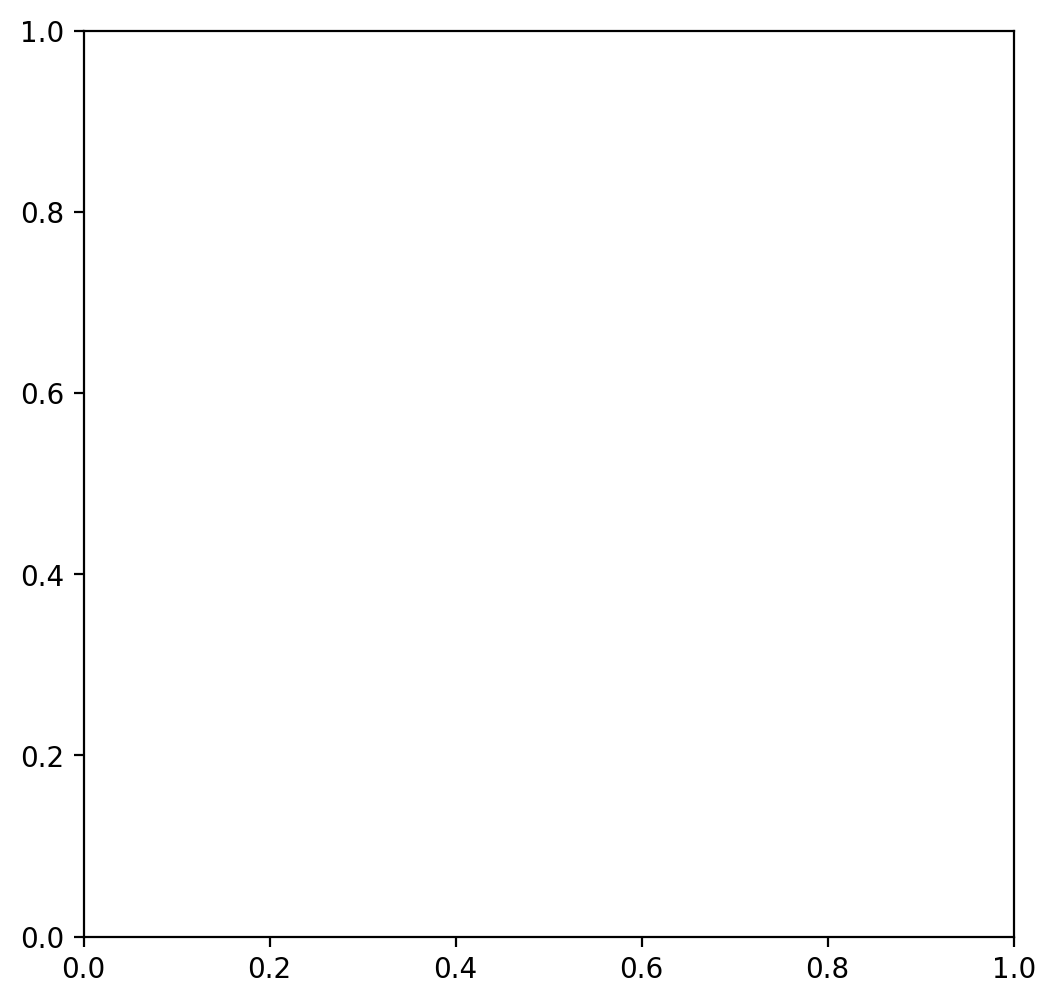

In [28]:
haloC = np.asarray([Lbox / 2 for i in range(3)])
RVir200, RVir500 = getRVir(tmax)
capturedIds = np.asarray([i if vMags[i, -1] < vEsc else 0 for i in range(vMags.shape[0])]).nonzero()[0]
fig = plt.figure(figsize=(6, 6), dpi=200)
fig.patch.set_facecolor("white")
ax = fig.gca()
axs = [ax]

colorArr = plt.cm.get_cmap('hsv', capturedIds.size)
# [axs[0].plot(xArr[i, 0, -1], xArr[i, 1, -1], 'ok') for i in capturedIds]

saveDir = homeDir + "LoopEvolHCPlt__nRockets_{:06d}__xi_{:03d}{}".format(vArr.shape[0], xi, Div)
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

tArr = np.arange(1, tmax)
T0 = time.time()
for ti, t in enumerate(tArr):
    print("Processing t = {:03d} ({:03d} / {:03d}), (Time Taken: {}, Time Estimated Remaining: {})".format(
        t, ti + 1, tArr.size, toMS(time.time() - T0), toMS((tArr.size / (ti + 1)) * (time.time() - T0))), end="\r")
    savePath = saveDir + "LoopEvolHCPlt__nRockets_{:06d}__xi_{:03d}__t_{:03d}.png".format(vArr.shape[0], xi, t)
    
    for i, cI in enumerate(capturedIds):
        xc = xArr[cI, 0, t]
        yc = xArr[cI, 1, t]
        dxA = xArr[cI, 0, t] - xArr[cI, 0, t - 1]
        dyA = xArr[cI, 1, t] - xArr[cI, 1, t - 1]
        axs[0].arrow(xc, yc, dxA, dyA, shape="full", length_includes_head=True, head_width=0.05, color='k')

        fadeIn = 15
        for j in range(t - 1):
            axs[0].plot(xArr[cI, 0, j:(j+2)], xArr[cI, 1, j:(j+2)], color=colorArr(i), alpha=math.pow((j / (t - 1)), fadeIn))


    pltLim = 2 * LHighRes
    for i, ax in enumerate(axs):
        ax.set_xlim([haloC[0] - pltLim, haloC[0] + pltLim])
        ax.set_ylim([haloC[1] - pltLim, haloC[1] + pltLim])
        ax.title.set_text("Captured Loop (Halo Centered) ({} rockets, xi = {}, t = {:03d})".format(vArr.shape[0], xi, t))
        ax.add_patch(plt.Circle((haloC[0], haloC[1]), RVir200, fill=False, linewidth=2, zorder=10))
    
    plt.savefig(savePath)
    print(" " * 100, end="\r")
    ax.cla()

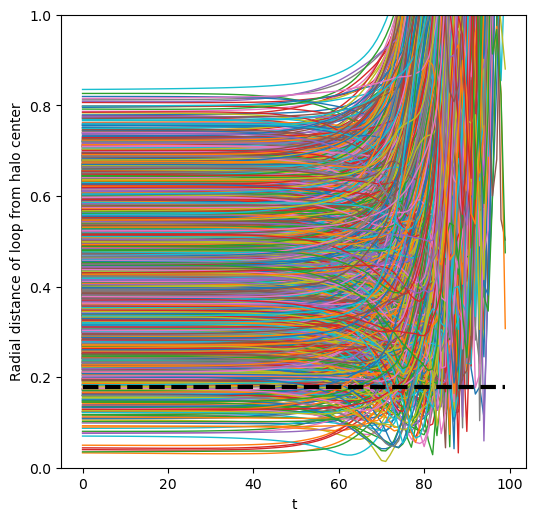

In [12]:
rocketDir = homeDir + "RocketTrajs_HC\\"
rocketPath = rocketDir + "RT_HC__Run2__N_003400__xi_050.npy"
xArr, vArr = np.load(rocketPath)
RVir200 = 0.17783348

fig = plt.figure(figsize=(6, 6), dpi=100)
for i in range(xArr.shape[0]):
    radDist = np.asarray([np.linalg.norm(xArr[i, :, t] - boxC) for t in range(xArr.shape[2])])
    plt.plot(np.arange(tmax), radDist, linewidth=1)
plt.plot(np.arange(tmax), RVir200 * np.ones(tmax), '--k', linewidth=3)
plt.ylim([0, 1])
plt.xlabel("t")
plt.ylabel("Radial distance of loop from halo center")
plt.show()

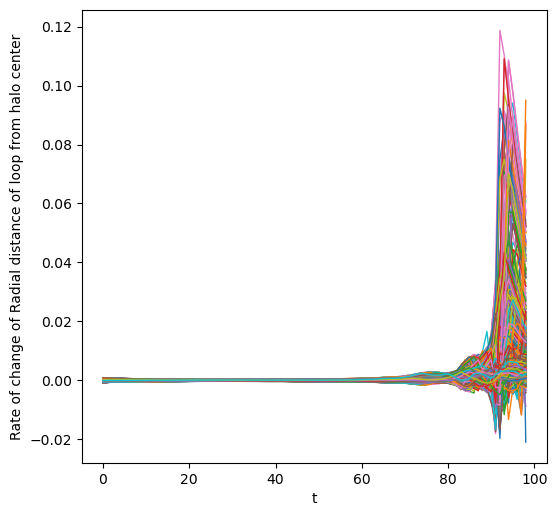

In [14]:
rocketDir = homeDir + "RocketTrajs_HC\\"
rocketPath = rocketDir + "RT_HC__Run2__N_003400__xi_050.npy"
xArr, vArr = np.load(rocketPath)
RVir200 = 0.17783348
tArr, aArr, HArr = getHubbleEvol()
dtArr = np.diff(tArr)

fig = plt.figure(figsize=(6, 6), dpi=100)
for i in range(xArr.shape[0]):
    radDist = np.asarray([np.linalg.norm(xArr[i, :, t] - boxC) for t in range(xArr.shape[2])])
    plt.plot(np.arange(tmax - 1), np.diff(radDist) / dtArr, linewidth=1)
# plt.plot(np.arange(tmax - 1), RVir200 * np.ones(tmax - 1), '--k', linewidth=3)
# plt.ylim([0, 1])
plt.xlabel("t")
plt.ylabel("Rate of change of Radial distance of loop from halo center")
plt.show()

In [10]:
FgArr = np.load(homeDir + "FgArr.npy")
FgMags = np.asarray([[np.linalg.norm(FgArr[i, :, t]) for t in range(FgArr.shape[2])] for i in range(FgArr.shape[0])])

In [31]:
nR = FgArr.shape[0]
tC = 90

Fgi = FgArr[int(nR / 2), :, tC]
print(xArr[int(nR / 2), :, tC])
[Fgi, np.linalg.norm(Fgi)]

[46.43890232 45.4828068  49.14356538]


[array([-3.98000822e-07, -2.04350009e-06, -5.42601184e-06]),
 5.811703860242597e-06]

In [13]:
nR = 0
tC = 80

Fgi = FgArr[int(nR / 2), :, tC]
print(xArr[int(nR / 2), :, tC])
[Fgi, np.linalg.norm(Fgi)]

[43.12007018 41.78354904 43.41764105]


[array([5.14744971e-09, 5.60797243e-10, 5.97730320e-09]),
 7.908153116586632e-09]

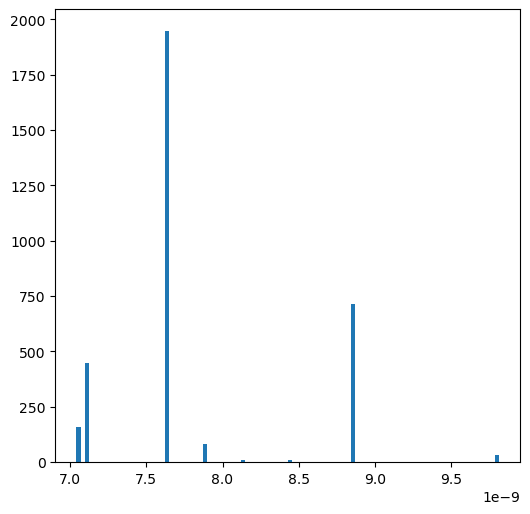

In [12]:
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.hist(FgMags[:, 0], bins=100)
plt.show()